In [13]:
import matplotlib.pyplot as plt
from matplotlib.ticker import NullLocator
import numpy as np
import glob
import pandas as pd
import json
import os

def make_heatmap(game_type, agent_type):
    df_r = pd.DataFrame()
    files = glob.glob("../data/" + game_type + "/" + agent_type + "/*.json")
    if len(files) == 0:
        return False
    for file in files:
        data = json.load(open(file))
        self_locs = data.get("data")["self_locs"]
        map = data.get("data")["map"]

        level_amt = len( data.get("data")["level"] )
        width = len(map[0][0])
        height = len(map[0])

        state_counts = np.zeros((width+1, height+1))

        # read encountered states
        for level in range(level_amt):
            if len( self_locs[level] ) == 0:
                continue
            action_amt = len(self_locs[level][0])
            for i in range( action_amt ):
                x = self_locs[level][0][i]
                y = self_locs[level][1][i]
                state_counts[x, y] += 1

        plt.imshow(state_counts.T, cmap='viridis')
        plt.gca().set_axis_off()
        plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0,
            hspace = 0, wspace = 0)
        plt.margins(0, 0)
        plt.gca().xaxis.set_major_locator(NullLocator())
        plt.gca().yaxis.set_major_locator(NullLocator())
        base = os.path.basename(file)

        path = "../data/heatmaps/" + game_type + "/" + agent_type + "/"
        if not os.path.exists(path):
            os.makedirs(path)

        filename = path + os.path.splitext(base)[0] + '_heatmap.jpg'
        plt.savefig(filename, bbox_inches='tight', pad_inches=0)
        #plt.close()
        return True

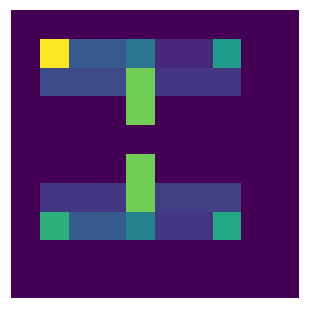

In [10]:
# make heapmap for logic_game with self_class
make_heatmap("logic_game", "self_class")

logic_game dqn_training
True
logic_game human
False
logic_game random
True
logic_game self_class
True
contingency_game dqn_training
True
contingency_game human
True
contingency_game random
True
contingency_game self_class
True


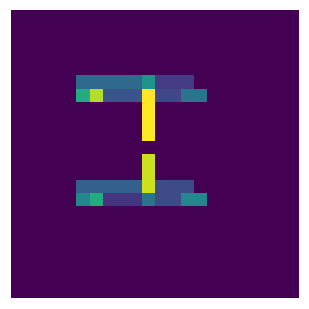

In [15]:
# make heatmap for all game types and agent types
game_types = ("logic_game", "contingency_game") #shuffle_keys
agent_types = ("dqn_training", "human", "random", "self_class")

for game in game_types:
    for agent in agent_types:
        make_heatmap(game, agent)
